# Constructing a Knowledge Graph-Based Deep Lake Vector Store for Semantic Search with LlamaIndex and OpenAI

copyright 2024, Denis Rothman

**A Practical Guide to Building a  Graph-Based Semantic Search Engine with Deep Lake, LlamaIndex, and OpenAI**

**Summary**

*   Pipeline 1 : Collecting and preparing the documents
*   Pipeline 2 : Creating and populating a Deep Lake Vector Store
*   Pipeline 3:  Index-based RAG.

**Topics**
*   Knowledge graph index-based semantic search and LLM response
*   Re-ranking
*   Metrics calculations and display




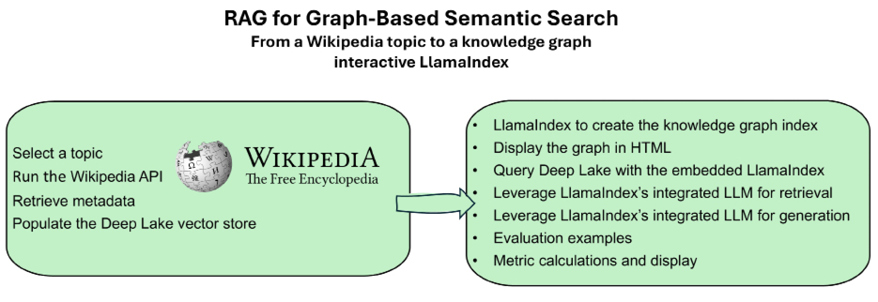

In [1]:
from IPython.display import Image
Image("./figures/image01.png", width=700, height=500)

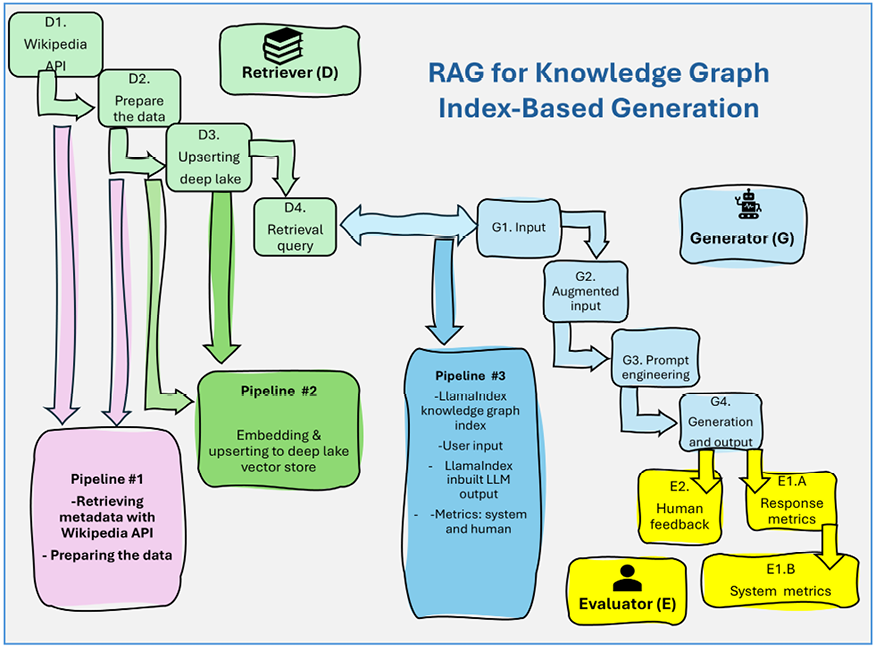

In [2]:
from IPython.display import Image
Image("./figures/image02.png", width=700, height=500)

# Installing the environment

In [3]:
# #Google Drive option to store API Keys
# #Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
import PIL
import subprocess

# Check current version of Pillow
current_version = PIL.__version__

# Define the required version
required_version = "10.2.0"

# Function to parse version strings
def version_tuple(version):
    return tuple(map(int, (version.split("."))))

# Compare current and required version
if version_tuple(current_version) < version_tuple(required_version):
    print(f"Current Pillow version {current_version} is less than {required_version}. Updating...")
    # Uninstall current version of Pillow
    subprocess.run(['pip', 'uninstall', 'pillow', '-y'])
    # Install the required version of Pillow
    subprocess.run(['pip', 'install', f'pillow=={required_version}'])
else:
    print(f"Current Pillow version {current_version} meets the requirement.")

Current Pillow version 10.2.0 meets the requirement.


Restart session before continuing to meet the Pillow version requirement:   
Go to Runtime->Restart Session  
You can then select Run all or run the program cell by cell.

In [5]:
# !pip install llama-index-vector-stores-deeplake==0.1.2

LlamaIndex supports Deep Lake vector stores through the DeepLakeVectorStore class.

In [6]:
# !pip install deeplake==3.9.8

In [7]:
# !pip install llama-index==0.10.37

Next, let's import the required modules and set the needed environmental variables:

In [8]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.vector_stores.deeplake import DeepLakeVectorStore
from llama_index.core import StorageContext

/Users/mjack6/GSU_Spring2025/MSA8700/venv_agenticai_frameworks/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [9]:
# !pip install pyvis==0.3.2

In [10]:
#Retrieving and setting the OpenAI API key
# f = open("drive/MyDrive/files/api_key.txt", "r")
# openai_api_key=f.readline()
# f.close()

openai_api_key = open("/Users/mjack6/.secrets/openai_mjack.apikey", "r").read().strip()

#The OpenAI KeyActiveloop and OpenAI API keys
import os
import openai
os.environ['OPENAI_API_KEY'] = openai_api_key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [11]:
#Retrieving and setting the Activeloop API token
# f = open("drive/MyDrive/files/activeloop.txt", "r")
# API_token=f.readline()
# f.close()

API_token = open("/Users/mjack6/.secrets/activeloop_mjack.apikey", "r").read().strip()

ACTIVELOOP_TOKEN=API_token
os.environ['ACTIVELOOP_TOKEN'] =ACTIVELOOP_TOKEN

In [12]:
# For Google Colab and Activeloop while waiting for Activeloop (April 2024) pending new version
#This line writes the string "nameserver 8.8.8.8" to the file. This is specifying that the DNS server the system
#should use is at the IP address 8.8.8.8, which is one of Google's Public DNS servers.
with open('etc/resolv.conf', 'w') as file:
   file.write("nameserver 8.8.8.8")

## GitHub

In [13]:
def download(directory, filename):
    # The base URL of the image files in the GitHub repository
    base_url = 'https://raw.githubusercontent.com/Denis2054/RAG-Driven-Generative-AI/main/'

    # Complete URL for the file
    file_url = f"{base_url}{directory}/{filename}"

    # Use curl to download the file, including an Authorization header for the private token
    try:
        # Prepare the curl command with the Authorization header
        curl_command = f'curl -o {filename} {file_url}'

        # Execute the curl command
        subprocess.run(curl_command, check=True, shell=True)
        print(f"Downloaded '{filename}' successfully.")
    except subprocess.CalledProcessError:
        print(f"Failed to download '{filename}'. Check the URL, your internet connection and the file path")

# Scenario


In [14]:
#File name for file management
graph_name="Marketing"

# Path for vector store and dataset
# db="hub://denis76/marketing01"
db="./dataset_marketing01"
vector_store_path = db
dataset_path = db

#if True upserts data; if False, passes upserting and goes to connection
pop_vs=True
# if pop_vs==True, overwrite=True will overwrite dataset, False will append it:
ow=True

# Pipeline 1 : Collecting and preparing the documents

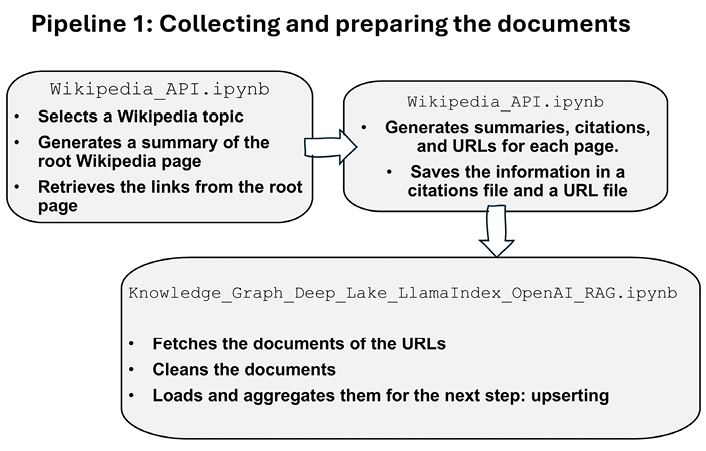

In [15]:
from IPython.display import Image
Image("./figures/image03.png", width=700, height=500)

In [16]:
# !mkdir data

In [17]:
# Define your variables
if pop_vs==True:
  directory = "Chapter07/citations"
  file_name = graph_name+"_urls.txt"
  download(directory,file_name)

Downloaded 'Marketing_urls.txt' successfully.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4856  100  4856    0     0  35842      0 --:--:-- --:--:-- --:--:-- 35970


In [18]:
# Read URLs from the file
import requests
from bs4 import BeautifulSoup
import re
import os

if pop_vs==True:
  directory = "Chapter07/citations"
  file_name = graph_name+"_urls.txt"

  with open(file_name, 'r') as file:
      urls = [line.strip() for line in file]

  # Display the URLs
  print("Read URLs:")
  for url in urls:
      print(url)

Read URLs:
https://en.wikipedia.org/wiki/Marketing
https://en.wikipedia.org/wiki/24-hour_news_cycle
https://en.wikipedia.org/wiki/Account-based_marketing
https://en.wikipedia.org/wiki/Activism
https://en.wikipedia.org/wiki/Adam_Smith
https://en.wikipedia.org/wiki/Adam_Smith_Institute
https://en.wikipedia.org/wiki/Advertising
https://en.wikipedia.org/wiki/Advertising_agency
https://en.wikipedia.org/wiki/Advertising_mail
https://en.wikipedia.org/wiki/Advertising_management
https://en.wikipedia.org/wiki/Advertising_slogan
https://en.wikipedia.org/wiki/Affinity_marketing
https://en.wikipedia.org/wiki/Agenda-setting_theory
https://en.wikipedia.org/wiki/Agricultural_Marketing_Service
https://en.wikipedia.org/wiki/Agricultural_marketing
https://en.wikipedia.org/wiki/Airborne_leaflet_propaganda
https://en.wikipedia.org/wiki/Alternative_facts
https://en.wikipedia.org/wiki/Alternative_media
https://en.wikipedia.org/wiki/American_Marketing_Association
https://en.wikipedia.org/wiki/American_busine

In [19]:
import requests
import re
import os
from bs4 import BeautifulSoup

def clean_text(content):
    # Remove references and unwanted characters
    content = re.sub(r'\[\d+\]', '', content)   # Remove references
    content = re.sub(r'[^\w\s\.]', '', content)  # Remove punctuation (except periods)
    return content

def fetch_and_clean(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise exception for bad responses (e.g., 404)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Prioritize "mw-parser-output" but fall back to "content" class if not found
        content = soup.find('div', {'class': 'mw-parser-output'}) or soup.find('div', {'id': 'content'})
        if content is None:
            return None

        # Remove specific sections, including nested ones
        for section_title in ['References', 'Bibliography', 'External links', 'See also', 'Notes']:
            section = content.find('span', id=section_title)
            while section:
                for sib in section.parent.find_next_siblings():
                    sib.decompose()
                section.parent.decompose()
                section = content.find('span', id=section_title)

        # Extract and clean text
        text = content.get_text(separator=' ', strip=True)
        text = clean_text(text)
        return text
    except requests.exceptions.RequestException as e:
        print(f"Error fetching content from {url}: {e}")
        return None  # Return None on error

if pop_vs==True:
  # Directory to store the output files
  output_dir = './data/'  # More descriptive name
  os.makedirs(output_dir, exist_ok=True)

  # Processing each URL (and skipping invalid ones)
  for url in urls:
      article_name = url.split('/')[-1].replace('.html', '')  # Handle .html extension
      filename = os.path.join(output_dir, f"{article_name}.txt")

      clean_article_text = fetch_and_clean(url)
      if clean_article_text:  # Only write to file if content exists
          with open(filename, 'w', encoding='utf-8') as file:
              file.write(clean_article_text)
  print(f"Content(ones that were possible) written to files in the '{output_dir}' directory.")

Content(ones that were possible) written to files in the './data/' directory.


In [20]:
if pop_vs==True:
  # load documents
  documents = SimpleDirectoryReader("./data/").load_data()
  # Print the first document
  print(documents[0])

Doc ID: 458ef653-bb62-43f7-b2ad-d8cfafabecd9
Text: Investigation and reporting of news concomitant with fastpaced
lifestyles This article is about the fastpaced cycle of news media in
technologically advanced societies. For the longerterm cycle of news
and information see information cycle . Several simultaneous NBC News
broadcasts including MSNBC  NBC s Today and CNBC s Squawk Box
displayed on...


# Pipeline 2 : Creating and populating the Deep Lake Vector Store

In [21]:
if pop_vs==True:
    # Create an index over the documents
    # overwrite=True will overwrite dataset, False will append it
    if ow==True:
       vector_store = DeepLakeVectorStore(dataset_path=dataset_path, overwrite=True)
    else:
        vector_store = DeepLakeVectorStore(dataset_path=dataset_path, overwrite=False)

    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    # Create an index over the documents
    index = VectorStoreIndex.from_documents(documents, storage_context=storage_context)

Uploading data to deeplake dataset.


100%|██████████| 860/860 [00:00<00:00, 1282.34it/s]

Dataset(path='./dataset_marketing01', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
   text       text      (860, 1)      str     None   
 metadata     json      (860, 1)      str     None   
 embedding  embedding  (860, 1536)  float32   None   
    id        text      (860, 1)      str     None   


In [22]:
import deeplake
ds = deeplake.load(dataset_path)  # Loads the dataset

./dataset_marketing01 loaded successfully.



In [23]:
ds.summary()

Dataset(path='./dataset_marketing01', tensors=['embedding', 'id', 'metadata', 'text'])

  tensor      htype       shape      dtype  compression
  -------    -------     -------    -------  ------- 
 embedding  embedding  (860, 1536)  float32   None   
    id        text      (860, 1)      str     None   
 metadata     json      (860, 1)      str     None   
   text       text      (860, 1)      str     None   


In [24]:
import json
import pandas as pd
import numpy as np

# Assuming 'ds' is your loaded Deep Lake dataset

# Create a dictionary to hold the data
data = {}

# Iterate through the tensors in the dataset
for tensor_name in ds.tensors:
    tensor_data = ds[tensor_name].numpy()

    # Check if the tensor is multi-dimensional
    if tensor_data.ndim > 1:
        # Flatten multi-dimensional tensors
        data[tensor_name] = [np.array(e).flatten().tolist() for e in tensor_data]
    else:
        # Convert 1D tensors directly to lists and decode text
        if tensor_name == "text":
            data[tensor_name] = [t.tobytes().decode('utf-8') if t else "" for t in tensor_data]
        else:
            data[tensor_name] = tensor_data.tolist()

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(data)

In [25]:
# Function to display a selected record
def display_record(record_number):
    record = df.iloc[record_number]
    display_data = {
        "ID": record.get("id", "N/A"),
        "Metadata": record.get("metadata", "N/A"),
        "Text": record.get("text", "N/A"),
        "Embedding": record.get("embedding", "N/A")
    }

    # Print the ID
    print("ID:")
    print(display_data["ID"])
    print()

    # Print the metadata in a structured format
    print("Metadata:")
    metadata = display_data["Metadata"]
    if isinstance(metadata, list):
        for item in metadata:
            for key, value in item.items():
                print(f"{key}: {value}")
            print()
    else:
        print(metadata)
    print()

    # Print the text
    print("Text:")
    print(display_data["Text"])
    print()

    # Print the embedding
    print("Embedding:")
    print(display_data["Embedding"])
    print()

# Example usage
rec = 0  # Replace with the desired record number
display_record(rec)


ID:
['9fa43e5a-568c-476f-a794-8b23fd352e34']

Metadata:
file_path: /Users/mjack6/GSU_Spring2025/MSA8700/BuildingGenerativeAIBusinessSolutions/KnowledgeGraphs/graphrag_example_3/data/24-hour_news_cycle.txt
file_name: 24-hour_news_cycle.txt
file_type: text/plain
file_size: 7550
creation_date: 2025-04-07
last_modified_date: 2025-04-07
_node_content: {"id_": "9fa43e5a-568c-476f-a794-8b23fd352e34", "embedding": null, "metadata": {"file_path": "/Users/mjack6/GSU_Spring2025/MSA8700/BuildingGenerativeAIBusinessSolutions/KnowledgeGraphs/graphrag_example_3/data/24-hour_news_cycle.txt", "file_name": "24-hour_news_cycle.txt", "file_type": "text/plain", "file_size": 7550, "creation_date": "2025-04-07", "last_modified_date": "2025-04-07"}, "excluded_embed_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"], "excluded_llm_metadata_keys": ["file_name", "file_type", "file_size", "creation_date", "last_modified_date", "last_accessed_date"]

## Original documents

In [26]:
# Ensure 'text' column is of type string
df['text'] = df['text'].astype(str)
# Create documents with IDs
documents = [Document(text=row['text'], doc_id=str(row['id'])) for _, row in df.iterrows()]

# Pipeline 3:Knowledge Graph Index-based RAG

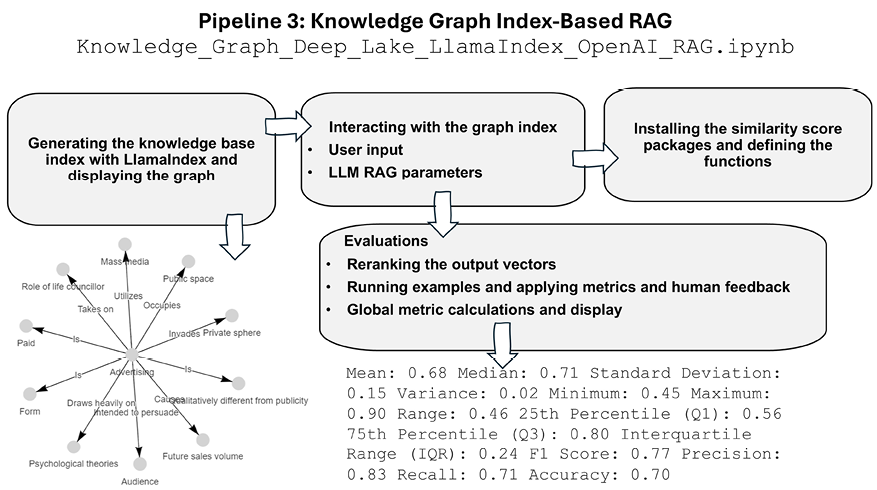

In [27]:
from IPython.display import Image
Image("./figures/image04.png", width=700, height=500)

## Generating the Knowledge Graph Index

In [28]:
from llama_index.core import KnowledgeGraphIndex
import time
# Start the timer
start_time = time.time()

#graph index with embeddings
graph_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=2,
    include_embeddings=True,
)

# Stop the timer
end_time = time.time()

# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Index creation time: {elapsed_time:.4f} seconds")

/var/folders/tj/cfj9qmvs7150dnbbhjnzz1tw0000gq/T/ipykernel_25855/852177030.py:7: DeprecationWarning: Call to deprecated class KnowledgeGraphIndex. (The KnowledgeGraphIndex class has been deprecated. Please use the new PropertyGraphIndex class instead. If a certain graph store integration is missing in the new class, please open an issue on the GitHub repository or contribute it!) -- Deprecated since version 0.10.53.
  graph_index = KnowledgeGraphIndex.from_documents(


Index creation time: 1027.7128 seconds


In [29]:
print(type(graph_index))

<class 'llama_index.core.indices.knowledge_graph.base.KnowledgeGraphIndex'>


In [30]:
#similarity_top_k
k=3
#temperature
temp=0.1
#num_output
mt=1024
graph_query_engine = graph_index.as_query_engine(similarity_top_k=k, temperature=temp, num_output=mt)

### Displaying the graph

In [31]:
## create graph
from pyvis.network import Network

g = graph_index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)

# Set node and edge properties: colors and sizes
for node in net.nodes:
    node['color'] = 'lightgray'
    node['size'] = 10

for edge in net.edges:
    edge['color'] = 'black'
    edge['width'] = 1

In [32]:
fgraph="Knowledge_graph_"+ graph_name + ".html"
net.write_html(fgraph)
print(fgraph)

Knowledge_graph_Marketing.html


In [33]:
from IPython.display import HTML

# Load the HTML content from a file and display it
with open(fgraph, 'r') as file:
    html_content = file.read()

# Display the HTML in the notebook
display(HTML(html_content))

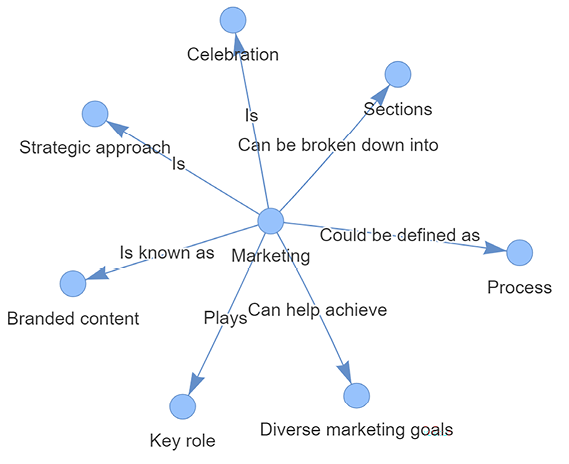

In [34]:
from IPython.display import Image
Image("./figures/image05.png", width=700, height=500)

## Interacting with the Knowledge graph index

### User input and RAG functions

In [35]:
import time
import textwrap

def execute_query(user_input, k=3, temp=0.1, mt=1024):

    # Start the timer
    start_time = time.time()

    # Execute the query with additional parameters
    response = graph_query_engine.query(user_input)

    # Stop the timer
    end_time = time.time()

    # Calculate and print the execution time
    elapsed_time = end_time - start_time
    print(f"Query execution time: {elapsed_time:.4f} seconds")

    # Print the response, wrapped to 100 characters per line
    print(textwrap.fill(str(response), 100))
    return response

In [36]:
user_query="What is the primary goal of marketing for the consumer market?"

In [37]:
import time
import textwrap
import sys
import io
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(response), 100))

Query execution time: 1.7058 seconds
The primary goal of marketing for the consumer market is to reach out to consumers and aim to
promote consumption.


## Installing the similarity score packages and defining the functions

Install the package(s) that fit your project.

In [38]:
# from google.colab import userdata
# userdata.get('HF_TOKEN')

HF_TOKEN = open("/Users/mjack6/.secrets/hugginface_mjack.apikey", "r").read().strip()
os.environ['HF_TOKEN'] = HF_TOKEN

In [39]:
# !pip install sentence-transformers==3.0.1

In [40]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_cosine_similarity_with_embeddings(text1, text2):
    embeddings1 = model.encode(text1)
    embeddings2 = model.encode(text2)
    similarity = cosine_similarity([embeddings1], [embeddings2])
    return similarity[0][0]

/Users/mjack6/GSU_Spring2025/MSA8700/venv_agenticai_frameworks/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [41]:
import time
import textwrap
import sys
import io

# Re-ranking

In [42]:
user_query="Which experts are often associated with marketing theory?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")

print(textwrap.fill(str(response), 100))

Query execution time: 1.7633 seconds
Brian Jones, Mark Tadajewski, Philip Kotler, and Kevin Lane Keller are often associated with
marketing theory.


In [43]:
# prompt: read the code above and write a python code to find out what type of object "response" is
type(response)

llama_index.core.base.response.schema.Response

In [44]:
text2=user_query # User query scenario
#text2=user_query # human feedbak

In [45]:
# Assuming 'response' is the object containing the source_nodes
best_rank=""
best_score=0
best_text=""
for idx, node_with_score in enumerate(response.source_nodes):
    node = node_with_score.node
    print(f"Node {idx + 1}:")
    print(f"Score: {node_with_score.score}")
    print(f"ID to rank: {node.id_}")
    print("Relationships:")
    for relationship, info in node.relationships.items():
        print(f"  Relationship: {relationship}")
        print(f"    Node ID: {info.node_id}")
        print(f"    Node Type: {info.node_type}")
        print(f"    Metadata: {info.metadata}")
        print(f"    Hash: {info.hash}")
    #print(f"Text to rank: {node.text}")
    print(textwrap.fill(str(node.text), 100))
    print(f"Mimetype: {node.mimetype}")
    print(f"Start Char Index: {node.start_char_idx}")
    print(f"End Char Index: {node.end_char_idx}")
    print(f"Text Template: {node.text_template}")
    print(f"Metadata Template: {node.metadata_template}")
    print(f"Metadata Separator: {node.metadata_seperator}")
    text1=node.text
    #text2=user_query
    similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
    print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
    if similarity_score3>best_score:
      best_score=similarity_score3
      best_rank=idx + 1
      best_text=node.text
      print(f"Best Rank: {best_rank}")
      print(f"Best Score: {best_score}")
      print(f"Best Text: {best_text}")
    print("\n" + "="*40 + "\n")

print(f"Best Rank: {best_rank}")
print(f"Best Score: {best_score}")
#print(f"Best Text: {best_text}")
print(textwrap.fill(str(best_text), 100))

Node 1:
Score: 1000.0
ID to rank: e4349d2f-dc5c-4c90-9a0f-14ac78d61559
Relationships:
  Relationship: NodeRelationship.SOURCE
    Node ID: ['dd074401-ebad-4252-8e53-c70b4d636996']
    Node Type: ObjectType.DOCUMENT
    Metadata: {}
    Hash: fc731bb83eada5b11640a96242c61826d104d3062fbf299fca027d4a671726dc
['Brian Jones Mark Tadajewski eds The Routledge Companion to Marketing History Oxon Routledge 2016
p. 108  Bakker F. Building Knowledge about the Consumer The Emergence of Market Research in the
Motion Picture Industry Business History  vol. 45 no. 1 2003 pp 101127  American Marketing
Association AMA Online  Karmasin H. Ernest Dichters Studies on Automobile Marketing in Schwarzkopf
S. and Gries R. eds. Ernest Dichter and Motivation Research New Perspectives on the Making of
Postwar Consumer Culture  Palgrave Macmillan 2010 p. 109125  Clow K.E. and James K.E. Essentials of
Marketing Research Putting Research Into Practice  Thousand Oaks Ca Sage 2010 p. 10  Nair S. R.
Market Research Te

# Examples for metrics

In [46]:
import numpy as np
import sys
# create an empty array score human feedback scores:
rscores =[]
# create an empty score for similarity function scores
scores=[]

## 1

In [47]:
user_query="Which experts are often associated with marketing theory?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 1.8291 seconds
Brian Jones, Mark Tadajewski, Philip Kotler, and Kevin Lane Keller are often associated with
marketing theory.


In [48]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.75
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.766


## 2

In [49]:
user_query="How does marketing boost sales?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 2.2513 seconds
Marketing can boost sales by helping a firm achieve diverse marketing goals such as promoting its
corporate identity, boosting employee morale, building greater investor confidence, and encouraging
sales. It can also strengthen relationships with employees, customers, and investors, leading to
increased sales.


In [50]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.5
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.809


## 3

In [51]:
user_query="What is the difference between B2B and B2C?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 1.6051 seconds
B2B businesses sell products and services to other companies, while B2C businesses sell directly to
customers.


In [52]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.8
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.760


## 4

In [53]:
user_query="What are the 4Ps? What do they stand for?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 2.0068 seconds
The 4Ps stand for Product, Price, Promotion, and Place.


In [54]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.9
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.853


## 5

In [55]:
user_query="What are the 4Cs? What do they stand for?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 2.5576 seconds
The 4Cs of marketing mix stand for Commodity, Cost, Communication, and Channel.


In [56]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.65
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.503


## 6

In [57]:
user_query="What is the difference between the 4Ps and 4Cs?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 2.8249 seconds
The difference between the 4Ps and 4Cs lies in their focus areas. The 4Ps, which are Product, Price,
Promotion, and Place, are elements of the traditional marketing mix that concentrate on the
company's perspective in creating and promoting a product. On the other hand, the 4Cs, which are
Commodity, Cost, Communication, and Channel, shift the focus towards the customer's viewpoint by
emphasizing aspects like customer needs, communication, and convenience in the marketing strategy.


In [58]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.8
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.769


## 7

In [59]:
user_query="What commodity programs does the Agricultural Marketing Service (AMS) maintain?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 3.8506 seconds
The Agricultural Marketing Service (AMS) maintains programs in five commodity areas: cotton and
tobacco, dairy, fruit and vegetable, livestock and seed, and poultry.


In [60]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.9
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.904


## 8

In [61]:
user_query="What kind of marketing is Got Milk?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 2.6543 seconds
Direct response marketing.


In [62]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.2
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.475


## 9

In [63]:
user_query="What an is industry trade group, business association, sector association or industry body?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 1.9538 seconds
A professional association for marketing professionals is an industry trade group, business
association, sector association, or industry body.


In [64]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.2
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.655


## 10

In [65]:
user_query="How many members are there in the American Marketing Association (AMA), theassociation for marketing professionals?"
# Start the timer
start_time = time.time()
# Capture the output
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
response = execute_query(user_query)
# Restore stdout
sys.stdout = old_stdout
# Stop the timer
end_time = time.time()
# Calculate and print the execution time
elapsed_time = end_time - start_time
print(f"Query execution time: {elapsed_time:.4f} seconds")
print(textwrap.fill(str(response), 100))

Query execution time: 1.6414 seconds
30000 members


In [66]:
text1=str(response)
text2=user_query
similarity_score3=calculate_cosine_similarity_with_embeddings(text1, text2)
print(f"Cosine Similarity Score with sentence transformer: {similarity_score3:.3f}")
scores.append(similarity_score3)
human_feedback=0.9
rscores.append(human_feedback)

Cosine Similarity Score with sentence transformer: 0.474


## Metrics calculation and display

In [67]:
print(len(scores), scores)
print(len(rscores), rscores)

10 [0.7659208, 0.80880076, 0.7599531, 0.85337156, 0.50336516, 0.76889664, 0.90369654, 0.474818, 0.65542126, 0.4744867]
10 [0.75, 0.5, 0.8, 0.9, 0.65, 0.8, 0.9, 0.2, 0.2, 0.9]


Mean, Median, Standard Deviation, Variance, Minimum, Maximum, Range, Percentile (Q1), 75th Percentile and Interquartile Range (IQR)

In [68]:
# Calculating metrics
mean_score = np.mean(scores)
median_score = np.median(scores)
std_deviation = np.std(scores)
variance = np.var(scores)
min_score = np.min(scores)
max_score = np.max(scores)
range_score = max_score - min_score
percentile_25 = np.percentile(scores, 25)
percentile_75 = np.percentile(scores, 75)
iqr = percentile_75 - percentile_25

# Printing the metrics with 2 decimals
print(f"Mean: {mean_score:.2f}")
print(f"Median: {median_score:.2f}")
print(f"Standard Deviation: {std_deviation:.2f}")
print(f"Variance: {variance:.2f}")
print(f"Minimum: {min_score:.2f}")
print(f"Maximum: {max_score:.2f}")
print(f"Range: {range_score:.2f}")
print(f"25th Percentile (Q1): {percentile_25:.2f}")
print(f"75th Percentile (Q3): {percentile_75:.2f}")
print(f"Interquartile Range (IQR): {iqr:.2f}")

Mean: 0.70
Median: 0.76
Standard Deviation: 0.15
Variance: 0.02
Minimum: 0.47
Maximum: 0.90
Range: 0.43
25th Percentile (Q1): 0.54
75th Percentile (Q3): 0.80
Interquartile Range (IQR): 0.26
